CAN BE COMPLEXIFIED 

satistical significance 

http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0018961&type=printable

In [1]:
library(igraph)
library(proxy)
library(NMI)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix



In [2]:
community_fitness <- function(A_G, A_H, alpha) {
    
    # edges in community
    d_in <- sum(A_H)
    
    # edges out of community
    d_out <- sum(A_G[!rownames(A_G)%in%rownames(A_H), rownames(A_H)])
    
    if (is.na(d_in / (d_in + d_out) ** alpha)){
        print("NAN")
        print(d_in)
        print(d_out)
        print(A_G[!rownames(A_G)%in%rownames(A_H), rownames(A_H)])
        print(A_H)
        stop()
    }
    
    return(d_in / (d_in + d_out) ** alpha)
}

community_neighbours <- function(A_G, A_H) {
        
    # nodes not in community
    other_nodes <- rownames(A_G)[!rownames(A_G)%in%rownames(A_H)]
    
    if (length(other_nodes) == 1) {
        return(other_nodes)
    }
        
    # connections to H
    C <- A_G[other_nodes, rownames(A_H)]

    # filter C for rows with a connection
    if (class(C) == "matrix") {
        return(rownames(C)[apply(C, 1, function(row) any(row > 0))])        
            
    } else return(names(C)[C > 0]) # H only contains one node so C is a vector
}
                 
node_fitness <- function(A_G, A_H, alpha, v) {
    
    # adjacency matrix of H with v
    A_H_add <- A_G[unique(c(rownames(A_H), v)), unique(c(colnames(A_H), v))]
    
    # adjacency matrix of H without v
    A_H_remove <- as.matrix(A_G[rownames(A_H)[rownames(A_H) != v], colnames(A_H)[colnames(A_H) != v]])
    rownames(A_H_remove) <- rownames(A_H)[rownames(A_H) != v]
    colnames(A_H_remove) <- colnames(A_H)[colnames(A_H) != v]
    
    return(community_fitness(A_G, A_H_add, alpha) - 
          community_fitness(A_G, A_H_remove, alpha))
}

In [3]:
greedy_community_search <- function(A_G, alpha=1.0, num_communities=100, overlaps_allowed=TRUE, min_community_size=3) {
    
    # initialise list of communities dicovered
    communities <- list()
    # discard isolated nodes
    connected_nodes <- rownames(A_G)[apply(A_G, 1, function(row) any(row > 0))]
    # vector of whether each node has been asigned to at least oine community
    node_assigned <- rep(FALSE, length(connected_nodes))
    names(node_assigned) <- connected_nodes
    # initiliase community counter
    community <- 1
    # proceed until all nodes are assgined or enough communities have been found
    while (!all(node_assigned) && community < num_communities) {
        
        #select random seed node from uncovered nodes
        r <- sample(1:sum(!node_assigned), 1)
        v <- names(node_assigned)[!node_assigned][r]

        # initialise community (as adjacancy matrix A_H) with seed node
        A_H <- as.matrix(A_G[v, v])
        rownames(A_H) <- v
        colnames(A_H) <- v
        
        # neighbours of community
        neighbours <- community_neighbours(A_G, A_H)

        # main loop: continue until no neiughbours can be found
        while(length(neighbours) > 0) {
            
            # calculate fitness of neighbours
            neighbour_fitnesses <- sapply(neighbours, function(neighbour) node_fitness(A_G, A_H, alpha, neighbour))
            names(neighbour_fitnesses) <- neighbours

            # add best neighbour to H
            if (max(neighbour_fitnesses) > 0) {
                # determine best neighbour
                best_neighbour <- names(neighbour_fitnesses)[which.max(neighbour_fitnesses)]
                # create new adjacency matrix for H
                A_H <- A_G[c(rownames(A_H), best_neighbour), c(colnames(A_H), best_neighbour)]
            } else break # No neighbour has positive fitness 
                
            # continuously evaluate fitness of all nodes in H and remove nodes with negative fitness
            node_fitnesses <- sapply(rownames(A_H), function(v) node_fitness(A_G, A_H, alpha, v)) 

            while (any(node_fitnesses <= 0)){
                
                # remove all nodes with negative fitness
                A_H_new <- as.matrix(A_G[rownames(A_H)[node_fitnesses > 0], colnames(A_H)[node_fitnesses > 0]])
                rownames(A_H_new) <- rownames(A_H)[node_fitnesses > 0]
                colnames(A_H_new) <- colnames(A_H)[node_fitnesses > 0]

                # update A_H
                A_H <- A_H_new

                # break if only one node
                if (length(rownames(A_H)) == 1) break
                    
                # recalulate node fitnesses    
                node_fitnesses <- sapply(rownames(A_H), function(v) node_fitness(A_G, A_H, alpha, v)) 
                
            } 
                    
            # neighbours of community
            neighbours <- community_neighbours(A_G, A_H)

        }
                    
        # check that community is not a duplicate
        if (any(sapply(communities, function(com) all(rownames(A_H)%in%com)))) break
            
        # assign all nodes in A_H to this community
        communities[[community]] <- rownames(A_H)
                    
        # mark each node in this community as assigned
        node_assigned[rownames(A_H)] <- TRUE
                    
        if (!overlaps_allowed) {
            # remove community from network
            nodes_to_keep <- rownames(A_G)[!rownames(A_G)%in%rownames(A_H)]
            A_G <- A_G[nodes_to_keep, nodes_to_keep]
            if (is.null(dim(A_G))){
                A_G <- matrix(A_G)
                rownames(A_G) <- nodes_to_keep
                colnames(A_G) <- nodes_to_keep
            }
        }            
                                
        #increment community counter
        community <- community + 1
    }     
                                         
    #return community list
    return(communities)
}



In [4]:
increment_consensus_matrix <- function(consensus_matrix, community_list) {

    # iterate over list of communities
    for (community in community_list) {
        
        if(length(community) == 0) next
            
        # iterate over pairs of nodes and increase the pairwise weight in consensus matrix
        for (i in 1:length(community)) {
            n_1 <- community[i]
            for (j in i:length(community)) {
                if (i == j) next
                n_2 <- community[j] 
                    
                # increment consensus matrix
                consensus_matrix[n_1, n_2] <- consensus_matrix[n_1, n_2] + 1
                consensus_matrix[n_2, n_1] <- consensus_matrix[n_2, n_1] + 1                
            }
        }
    } 
        
    return(consensus_matrix)
    
}

In [5]:
adjacency_matrix_to_consensus_matrix <- function(A_G, alpha=1.0, 
                                                 num_repeats=100, num_communities=100, 
                                                 overlaps_allowed=TRUE, normalise=FALSE, filter="50%") {
    
    # run algorithm num_repeats times
    community_assignments <- lapply(1:num_repeats, function(i) 
        greedy_community_search(A_G, alpha=alpha, num_communities=num_communities, overlaps_allowed=overlaps_allowed))
    
    # convert to consensus matrix
    # initialise consensus matrix
    consensus_matrix <- matrix(0, nrow=nrow(A_G), ncol=ncol(A_G))
    rownames(consensus_matrix) <- rownames(A_G)
    colnames(consensus_matrix) <- colnames(A_G)
    
    # update consensus matrix
    for (community_assignment in community_assignments) {
        consensus_matrix <- increment_consensus_matrix(consensus_matrix, community_assignment)
    }
        
    # normalisation 
    if (normalise) {
        consensus_matrix <- consensus_matrix / num_repeats
    }    
    
    # filter consensus matrix
    consensus_matrix[consensus_matrix < quantile(consensus_matrix)[filter]] <- 0
        
    return(consensus_matrix)
}

In [185]:
# read in graph
G <- read.graph("embedded_yeast_uetz.gml", "gml")

# weight by similarity
S1 <- as.matrix(as_adj(G))
S2 <- 1 - as.matrix(dist(S1, method = "cosine"))

# weighting of second order similarity
w1 <- 0

# create weighted adjacancy matrix
A_G <- S1 + w1 * S2
rownames(A_G) <- V(G)
colnames(A_G) <- V(G)

# normalise similarity matrix
A_G <- A_G / max(A_G)

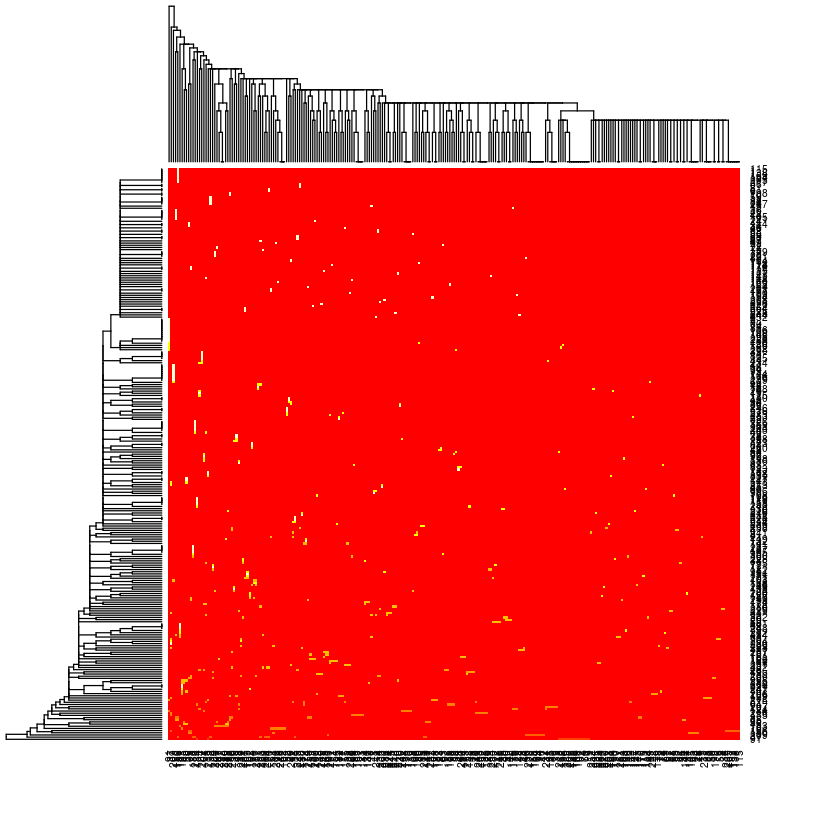

In [186]:
heatmap(A_G)

In [192]:
# resolution parameter(s)
alphas <- c(0.8, 1.0, 1.2)

# number of repeats
num_repeats <- 1

# number of iterations
num_iter <- 250

# filtering
tau <- 0.1

# weight decay
lambda <- 0.99

# convert to consensus matrix
consensus_matrix <- A_G 

In [193]:
for (iter in 1:num_iter) {
# while(!all(consensus_matrix %in% c(0,1))) {  
    for (alpha in alphas) {
            consensus_matrix <- lambda * consensus_matrix + 
            (1 - lambda) * adjacency_matrix_to_consensus_matrix(consensus_matrix, 
                                alpha=alpha, num_repeats = 1, overlaps_allowed=T,
                                                            normalise = T, filter="0%")
        }
        
        # filter 
#         consensus_matrix[consensus_matrix < quantile(consensus_matrix)["75%"]] <- 0
#         consensus_matrix[consensus_matrix < tau] <- 0
        
#     }
    
    # filter 
#     consensus_matrix[consensus_matrix < quantile(consensus_matrix)["75%"]] <- 0
    
    # obtain consensus matrix for each resolution
#     multi_scale_consensus_matrices <- lapply(alphas, function(alpha)
#         adjacency_matrix_to_consensus_matrix(consensus_matrix, alpha=alpha, 
#                                              num_repeats = num_repeats, overlaps_allowed = F, 
#                                              normalise = F, filter="75%"))   
        
#     # initialise consensus matrix
#     c_m <- matrix(0, nrow=nrow(A_G), ncol=ncol(A_G))
#     rownames(c_m) <- rownames(A_G)
#     colnames(c_m) <- colnames(A_G)
#     # sum consensus matrices for all scales
#     for (mat in multi_scale_consensus_matrices) {
#         c_m <- c_m + mat
#     }
        
#     # normalise consensus matrix
#     c_m  <- c_m / (length(alphas) * num_repeats)

#     #update consensus matrix
#     consensus_matrix <- lambda * consensus_matrix + (1 - lambda) * c_m
        
#     # filter consensus matrix
    
#     tau <- quantile(consensus_matrix[consensus_matrix > 0])["50%"]
#     consensus_matrix[consensus_matrix < tau] <- 0

#     iter <- iter + 1
}

# print(iter)

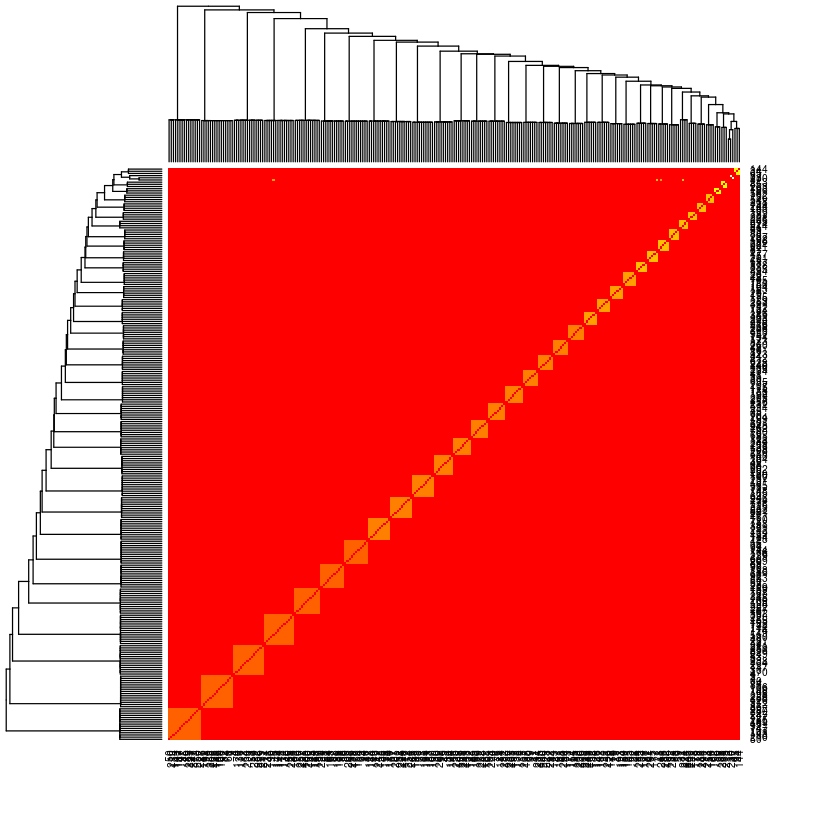

In [194]:
heatmap(consensus_matrix)

In [195]:
# cluster based on consensus matrix
communities <- greedy_community_search(consensus_matrix, alpha=1.0, overlaps_allowed = F)

# invert (for NMI)
assignments <- numeric(length = length(V(G)))
names(assignments) <- V(G)

for (i in 1:length(communities)) {
    for (node in communities[[i]]) {
        assignments[node] <- i
    }
}

In [196]:
communities

[[1]]
[1] "78"  "206" "179" "221"

[[2]]
[1] "44"  "223" "67"  "180" "212" "240" "235"

[[3]]
[1] "124" "19"  "29"  "193" "175" "17" 

[[4]]
 [1] "176" "209" "16"  "47"  "94"  "99"  "114" "166" "239" "66"  "89" 

[[5]]
 [1] "33"  "14"  "172" "174" "132" "5"   "142" "40"  "155" "46"  "231" "228"
[13] "190" "149"

[[6]]
[1] "20"  "42"  "140" "90"  "202" "104" "30"  "130" "25" 

[[7]]
[1] "84"  "161" "173" "260" "81"  "48"  "123"

[[8]]
[1] "95"  "236" "208" "169" "154" "171" "113"

[[9]]
 [1] "201" "233" "167" "225" "254" "52"  "116" "246" "27"  "77" 

[[10]]
[1] "134" "199" "75"  "232" "204" "6"   "70"  "51" 

[[11]]
 [1] "49"  "38"  "73"  "128" "242" "110" "184" "119" "151" "158"

[[12]]
[1] "243" "216" "35"  "126" "152" "203"

[[13]]
[1] "251" "139" "133" "249" "220" "122" "108" "55" 

[[14]]
 [1] "87"  "91"  "7"   "9"   "60"  "74"  "106" "109" "146" "195" "226" "258"
[13] "120" "86"  "112"

[[15]]
[1] "217" "156" "1"   "115" "138" "153" "197" "205"

[[16]]
 [1] "229" "57"  "68"  "28"  "97"  "186" "64"  "58"  "98"  "118" "163"

[[17]]
[1] "34"  "65"  "144"

[[18]]
[1] "192" "13"  "59"  "88"  "237"

[[19]]
 [1] "45"  "189" "255" "50"  "183" "107" "147" "227" "72"  "92"  "250" "210"
[13] "127" "143" "247"

[[20]]
[1] "252" "241" "196" "8"   "96" 

[[21]]
[1] "56"  "10"  "198"

[[22]]
[1] "262" "69"  "181" "62"  "101" "248" "79"  "160"

[[23]]
[1] "230" "37" 

[[24]]
 [1] "24"  "200" "102" "137" "222" "159" "76"  "103" "168" "257" "145" "125"

[[25]]
 [1] "211" "238" "219" "2"   "36"  "256" "4"   "53"  "82"  "117" "3"   "170"
[13] "259" "164"

[[26]]
[1] "224" "31"  "245" "214"

[[27]]
 [1] "148" "100" "185" "23"  "131" "157" "165" "93"  "63"  "71" 

[[28]]
[1] "136" "162" "54"  "218"

[[29]]
[1] "182" "32"  "253" "141" "129" "111"

[[30]]
[1] "85"  "263" "213"

[[31]]
[1] "41"  "207" "11"  "39"  "80"  "135" "234"

[[32]]
[1] "61"  "177" "261" "21"  "15"  "12" 

[[33]]
[1] "194" "83"  "215" "178" "187"

[[34]]
[1] "121" "150" "22"  "26"  "43"  "105"

[[35]]
[1] "18"  "191" "188" "244"

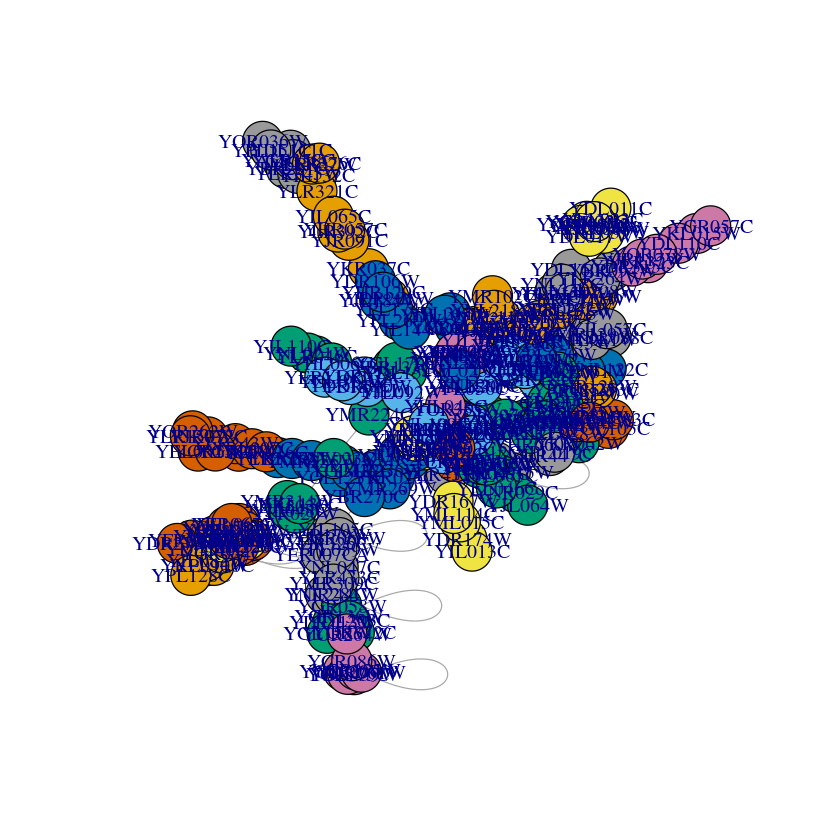

In [197]:
# plot G coloured by assignment 
plot.igraph(G, vertex.color=assignments)

In [184]:
true_df <- data.frame(node_id=V(G)$id, module=V(G)$club)
pred_df <- data.frame(node_id=V(G)$id, module=assignments)
NMI(true_df, pred_df)$value

[1] 0.693611

In [211]:
orfCommunities <- sapply(communities, function(com) vertex_attr(G, "label", com))

## GO Term Enrichment

In [198]:
library(topGO)
library(GOSemSim)
library(GOSim)
library(org.Sc.sgd.db)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:igraph’:

    normalize, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: graph

Attaching package: ‘g

In [199]:
scGO <- godata(OrgDb = "org.Sc.sgd.db", keytype = "ORF", ont = "BP")

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [213]:
clusterSim <- mclusterSim(orfCommunities, semData = scGO)

In [214]:
clusterSim

1.000,0.437,0.381,0.435,0.439,0.469,0.316,0.437,0.406,0.466,⋯,0.275,0.329,0.265,0.364,0.331,0.345,0.417,0.308,0.507,0.355
0.437,1.000,0.402,0.501,0.423,0.435,0.387,0.363,0.586,0.440,⋯,0.310,0.366,0.266,0.454,0.523,0.510,0.457,0.421,0.324,0.516
0.381,0.402,1.000,0.423,0.421,0.417,0.403,0.253,0.446,0.505,⋯,0.416,0.287,0.216,0.395,0.449,0.335,0.312,0.331,0.319,0.422
0.435,0.501,0.423,1.000,0.431,0.465,0.395,0.424,0.527,0.501,⋯,0.331,0.428,0.331,0.506,0.482,0.612,0.473,0.498,0.377,0.565
0.439,0.423,0.421,0.431,1.000,0.491,0.398,0.457,0.465,0.413,⋯,0.358,0.370,0.207,0.361,0.451,0.388,0.453,0.337,0.385,0.423
0.469,0.435,0.417,0.465,0.491,1.000,0.335,0.355,0.469,0.454,⋯,0.287,0.311,0.233,0.490,0.375,0.467,0.380,0.343,0.448,0.393
0.316,0.387,0.403,0.395,0.398,0.335,1.000,0.552,0.420,0.340,⋯,0.390,0.363,0.219,0.344,0.460,0.347,0.364,0.391,0.287,0.406
0.437,0.363,0.253,0.424,0.457,0.355,0.552,1.000,0.487,0.314,⋯,0.267,0.493,0.214,0.354,0.358,0.445,0.424,0.400,0.385,0.343
0.406,0.586,0.446,0.527,0.465,0.469,0.420,0.487,1.000,0.439,⋯,0.354,0.404,0.304,0.567,0.625,0.567,0.446,0.454,0.426,0.592
0.466,0.440,0.505,0.501,0.413,0.454,0.340,0.314,0.439,1.000,⋯,0.384,0.375,0.334,0.395,0.438,0.394,0.370,0.361,0.471,0.435
0.450,0.596,0.450,0.564,0.445,0.492,0.409,0.392,0.631,0.531,⋯,0.357,0.404,0.294,0.524,0.599,0.618,0.539,0.485,0.419,0.619


In [26]:
setEvidenceLevel(organism = org.Sc.sgdORGANISM, evidences = "all", gomap = org.Sc.sgdGO)
setOntology("BP", loadIC = F,)

initializing GOSim package ...
-> retrieving GO information for all available genes for organism 'human' in GO database
-> filtering GO terms according to evidence levels 'all'
-> loading files with information content for corresponding GO category (human)
finished.
-> retrieving GO information for all available genes for organism 'Saccharomyces cerevisiae' in GO database
-> filtering GO terms according to evidence levels 'all'


In [27]:
# filter out genes not in database
orfCommunities <- sapply(orfCommunities, function(com) com[com%in%keys(org.Sc.sgd.db)])

In [28]:
goEnrichmentResults <- sapply(orfCommunities, function(com) GOenrichment(com, allgenes = keys(org.Sc.sgd.db)))


Building most specific GOs .....
	( 2909 GO terms found. )

Build GO DAG topology ..........
	( 5064 GO terms and 11404 relations. )

Annotating nodes ...............
	( 6419 genes annotated to the GO terms. )

			 -- Elim Algorithm -- 

		 the algorithm is scoring 237 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	1 nodes to be scored	(0 eliminated genes)

	 Level 14:	1 nodes to be scored	(0 eliminated genes)

	 Level 13:	2 nodes to be scored	(0 eliminated genes)

	 Level 12:	3 nodes to be scored	(0 eliminated genes)

	 Level 11:	8 nodes to be scored	(0 eliminated genes)

	 Level 10:	16 nodes to be scored	(2 eliminated genes)

	 Level 9:	22 nodes to be scored	(2 eliminated genes)

	 Level 8:	27 nodes to be scored	(16 eliminated genes)

	 Level 7:	31 nodes to be scored	(16 eliminated genes)

	 Level 6:	35 nodes to be scored	(242 eliminated genes)

	 Level 5:	36 nodes to be scored	(242 eliminated genes)

	 Level 4:	29 nodes to be scored	(247 e

In [215]:
interClusterSim <- sapply(orfCommunities, function(com){
    sims <- mgeneSim(com, semData = scGO, verbose = F)
    return(mean(sims[upper.tri(sims)]))
})

In [216]:
interClusterSim

[1] 0.2565000 0.3752857 0.2370667 0.3617333 0.2353736 0.2638889 0.1854762
 [8] 0.2776667 0.2986667 0.2511071 0.2813556 0.2428667 0.2173810 0.2296381
[15] 0.1321071 0.2810889 0.4553333 0.1426000 0.2806795 0.4495000 0.1903333
[22] 0.3303333 0.1830000 0.3407424 0.2920128 0.3501667 0.2273611 0.3055000
[29] 0.3966000 0.9386667 0.2403810 0.2415333 0.1800000 0.1794000 0.2723333

In [31]:
GO_A <- mgeneSim(genes = V(G)$label, semData = scGO)

  |======================================================================| 100%


In [32]:
head(GO_A)

,YGR046W,YJL030W,YBR057C,YKR026C,YFL056C,YFL061W,YDR174W,YLR303W,YPL211W,YOL020W,⋯,YLR376C,YDR311W,YDR206W,YOL149W,YER065C,YNL218W,YOR078W,YPL019C,YGL153W,YDL002C
YGR046W,1.000,0.097,0.296,0.266,0.405,0.188,0.207,0.281,0.122,0.104,⋯,0.304,0.267,0.195,0.148,0.296,0.231,0.122,0.352,0.094,0.267
YJL030W,0.097,1.000,0.232,0.135,0.226,0.132,0.388,0.103,0.168,0.085,⋯,0.153,0.122,0.149,0.085,0.146,0.139,0.092,0.209,0.188,0.247
YBR057C,0.296,0.232,1.000,0.213,0.397,0.262,0.362,0.226,0.241,0.103,⋯,0.492,0.370,0.373,0.338,0.292,0.433,0.280,0.279,0.264,0.362
YKR026C,0.266,0.135,0.213,1.000,0.353,0.245,0.272,0.488,0.112,0.074,⋯,0.228,0.366,0.380,0.166,0.364,0.318,0.152,0.205,0.096,0.317
YFL056C,0.405,0.226,0.397,0.353,1.000,0.396,0.333,0.498,0.267,0.221,⋯,0.483,0.503,0.360,0.268,0.632,0.360,0.267,0.668,0.195,0.503
YFL061W,0.188,0.132,0.262,0.245,0.396,1.000,0.212,0.361,0.231,0.079,⋯,0.314,0.326,0.323,0.246,0.258,0.323,0.231,0.321,0.070,0.326


In [50]:
filter <- 0.45
GO_F <- GO_A
GO_F[GO_F < filter] <- 0

In [51]:
GO_G <- graph_from_adjacency_matrix(GO_F, weighted = T)

In [52]:
is_connected(GO_G)

[1] FALSE

In [53]:
edge_density(GO_G)

[1] 0.08704863

In [44]:
GO_F

,YGR046W,YJL030W,YBR057C,YKR026C,YFL056C,YFL061W,YDR174W,YLR303W,YPL211W,YOL020W,⋯,YLR376C,YDR311W,YDR206W,YOL149W,YER065C,YNL218W,YOR078W,YPL019C,YGL153W,YDL002C
YGR046W,1.000,0,0,0.000,0.405,0,0.000,0.000,0,0,⋯,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
YJL030W,0.000,1,0,0.000,0.000,0,0.000,0.000,0,0,⋯,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
YBR057C,0.000,0,1,0.000,0.000,0,0.000,0.000,0,0,⋯,0.492,0.000,0.000,0,0.000,0.433,0.000,0.000,0.000,0.000
YKR026C,0.000,0,0,1.000,0.000,0,0.000,0.488,0,0,⋯,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
YFL056C,0.405,0,0,0.000,1.000,0,0.000,0.498,0,0,⋯,0.483,0.503,0.000,0,0.632,0.000,0.000,0.668,0.000,0.503
YFL061W,0.000,0,0,0.000,0.000,1,0.000,0.000,0,0,⋯,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
YDR174W,0.000,0,0,0.000,0.000,0,1.000,0.000,0,0,⋯,0.000,0.538,0.000,0,0.000,0.000,0.000,0.000,0.000,0.634
YLR303W,0.000,0,0,0.488,0.498,0,0.000,1.000,0,0,⋯,0.000,0.000,0.000,0,0.507,0.000,0.000,0.000,0.000,0.000
YPL211W,0.000,0,0,0.000,0.000,0,0.000,0.000,1,0,⋯,0.000,0.000,0.000,0,0.000,0.000,0.536,0.000,0.000,0.000
YOL020W,0.000,0,0,0.000,0.000,0,0.000,0.000,0,1,⋯,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000


In [45]:
edge_density(G)

[1] 0.008475314

In [58]:
GOCommunities <- greedy_community_search(GO_F, alpha = 1.0)

In [59]:
interClusterSimGO <- sapply(GOCommunities, function(com){
    sims <- mgeneSim(com, semData = scGO, verbose = F)
    return(mean(sims[upper.tri(sims)]))
})

In [62]:
GOCommunities[[3]]

[1] "YKL039W" "YHR057C" "YPL229W" "YCR050C" "YLR046C" "YHR140W" "YGR268C"
 [8] "YNR029C" "YEL023C" "YOR284W" "YKL090W" "YCR022C" "YFR057W" "YPL260W"
[15] "YLR392C" "YOR062C" "YMR181C" "YDR061W" "YGL221C" "YGR117C" "YDR383C"
[22] "YMR102C" "YDL012C" "YMR226C" "YER079W" "YHL046C" "YOR264W" "YMR180C"
[29] "YBR094W" "YDL215C" "YDR214W" "YNL023C" "YML028W" "YER027C" "YDR477W"
[36] "YGL180W"

In [60]:
interClusterSimGO

[1] 0.5972857 0.5005000 0.8281556 0.4530000 0.6630000